In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# a

In [39]:
# Parameters
S0 = 270  # initial stock price
r = 0.0349  # risk-free rate
T = 30  # maturity time
mu = 0  # drift under real-world measure P
sigma = 0.1  # volatility
num_paths = 100  # number of sample paths
time_steps = 25  # number of time steps
dt = T / time_steps  # time increment

In [40]:
time_grid = np.linspace(0, T, time_steps + 1)

In [41]:
def simulate_gbm(S0, mu, sigma, T, time_steps, num_paths):
    dt = T / time_steps
    S = np.zeros((num_paths, time_steps + 1))
    S[:, 0] = S0
    for t in range(1, time_steps + 1):
        Z = np.random.normal(0, 1, num_paths)
        S[:, t] = S[:, t - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    return S

In [42]:
# Simulate under real-world measure P
S_P = simulate_gbm(S0, mu, sigma, T, time_steps, num_paths)

# Simulate under martingale measure Q (drift is replaced by risk-free rate r)
S_Q = simulate_gbm(S0, r, sigma, T, time_steps, num_paths)

In [43]:
B = np.exp(r * time_grid)  # bond price process
S_P_discounted = S_P / B
S_Q_discounted = S_Q / B

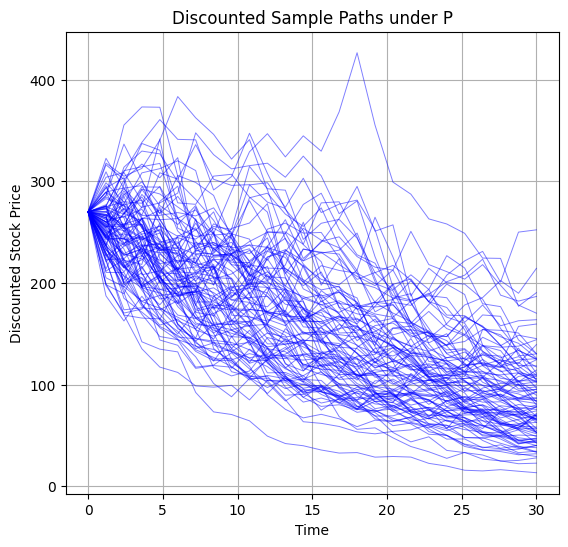

In [44]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
for i in range(num_paths):
    plt.plot(time_grid, S_P_discounted[i, :], color='blue', alpha=0.5, linewidth=0.7)
plt.title("Discounted Sample Paths under P")
plt.xlabel("Time")
plt.ylabel("Discounted Stock Price")
plt.grid(True)

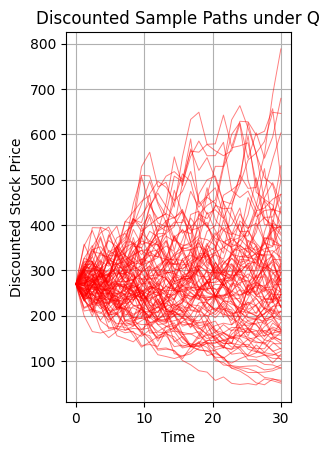

In [45]:
plt.subplot(1, 2, 2)
for i in range(num_paths):
    plt.plot(time_grid, S_Q_discounted[i, :], color='red', alpha=0.5, linewidth=0.7)
plt.title("Discounted Sample Paths under Q")
plt.xlabel("Time")
plt.ylabel("Discounted Stock Price")
plt.grid(True)

#### Under P, the paths tend to decline because the stock's drift does not compensate for the discounting. Under Q, the expected value of the discounted stock remains stable, reflecting the martingale property of the discounted stock price under the risk-neutral measure.

# b

In [46]:
K = 333

In [47]:

S_T_Q = S_Q[:, -1]  # stock prices at maturity (T = 30) under Q
payoffs_Q = np.maximum(S_T_Q - K, 0)  # payoff of the call option at maturity

# Discount the payoffs to present value
discount_factor = np.exp(-r * T)
present_value_payoffs = discount_factor * payoffs_Q

# Approximate the value of the claim using the average of the discounted payoffs
simulated_price = np.mean(present_value_payoffs)

In [48]:
def black_scholes_call_price(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [49]:
theoretical_price = black_scholes_call_price(S0, K, T, r, sigma)
simulated_price, theoretical_price

(np.float64(160.37163005356598), np.float64(155.71919850775316))

# c

In [50]:
num_paths = 250

In [51]:
S_Q_250 = simulate_gbm(S0, r, sigma, T, time_steps, num_paths)

In [52]:
max_S_T_Q = np.max(S_Q_250, axis=1) 
payoffs_Q_max = np.maximum(max_S_T_Q - K, 0)

In [53]:
present_value_payoffs_max = discount_factor * payoffs_Q_max

In [54]:
simulated_price_max = np.mean(present_value_payoffs_max)

In [55]:
std_dev = np.std(present_value_payoffs_max) / np.sqrt(num_paths)
confidence_interval = (
    simulated_price_max - 1.645 * std_dev,
    simulated_price_max + 1.645 * std_dev,
)
simulated_price_max, confidence_interval


(np.float64(166.18820933461154),
 (np.float64(151.48286437551383), np.float64(180.89355429370926)))

### plots

In [56]:
def estimate_option_price_max(S0, mu, sigma, r, K, T, time_steps, num_paths):
    S_Q = simulate_gbm(S0, mu, sigma, T, time_steps, num_paths)
    max_S_T_Q = np.max(S_Q, axis=1)  # maximum stock price along each path
    payoffs_Q_max = np.maximum(max_S_T_Q - K, 0)  # payoff of the call option at maturity
    discount_factor = np.exp(-r * T)
    present_value_payoffs_max = discount_factor * payoffs_Q_max
    return np.mean(present_value_payoffs_max)

In [57]:
volatility_range = np.linspace(0.05, 0.3, 10)
drift_range = np.linspace(-0.05, 0.05, 10)
interest_rate_range = np.linspace(0.01, 0.1, 10)
strike_price_range = np.linspace(250, 400, 10)

In [58]:
option_prices_volatility = [estimate_option_price_max(S0, r, sigma, r, K, T, time_steps, num_paths) for sigma in volatility_range]
option_prices_drift = [estimate_option_price_max(S0, mu, sigma, r, K, T, time_steps, num_paths) for mu in drift_range]
option_prices_interest_rate = [estimate_option_price_max(S0, r, sigma, rate, K, T, time_steps, num_paths) for rate in interest_rate_range]
option_prices_strike = [estimate_option_price_max(S0, r, sigma, r, k, T, time_steps, num_paths) for k in strike_price_range]


In [59]:
plt.figure(figsize=(14, 10))

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

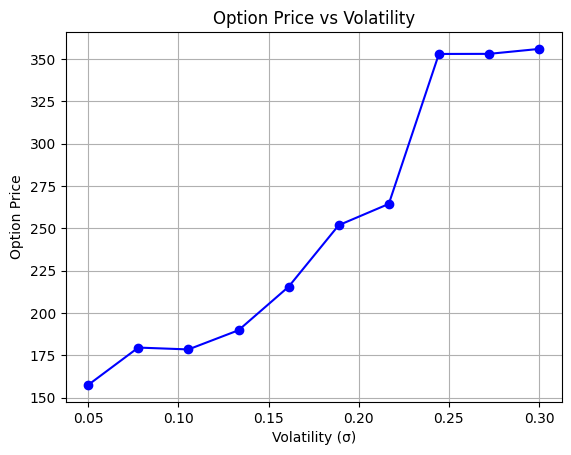

In [62]:
plt.plot(volatility_range, option_prices_volatility, marker='o', color='b')
plt.title('Option Price vs Volatility')
plt.xlabel('Volatility (\u03c3)')
plt.ylabel('Option Price')
plt.grid(True)

#### The option price increases as the volatility increases. Because higher volatility leads to greater potential for the underlying asset price to move favorably for the option holder, which increases the value of the option

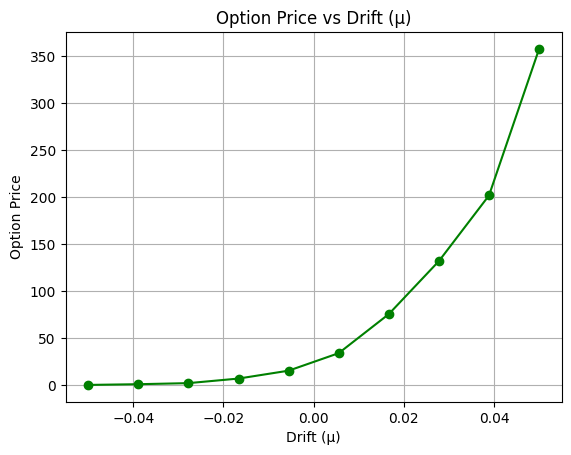

In [63]:
plt.plot(drift_range, option_prices_drift, marker='o', color='g')
plt.title('Option Price vs Drift (\u03bc)')
plt.xlabel('Drift (\u03bc)')
plt.ylabel('Option Price')
plt.grid(True)

#### The option price increases as the drift increases. A higher drift implies a higher average return, which in turn increases the likelihood of reaching higher maximum prices, thereby increasing the option value.

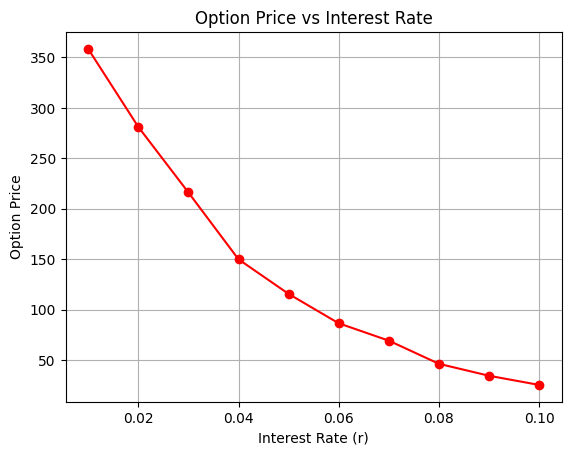

In [64]:
plt.plot(interest_rate_range, option_prices_interest_rate, marker='o', color='r')
plt.title('Option Price vs Interest Rate')
plt.xlabel('Interest Rate (r)')
plt.ylabel('Option Price')
plt.grid(True)

#### The option price decreases as the interest rate increases. This is because a higher discount factor is used to discount the future payoffs, reducing the present value of the option.

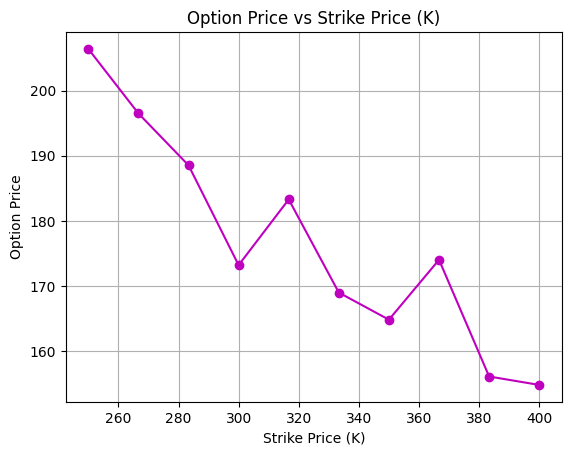

In [65]:
plt.plot(strike_price_range, option_prices_strike, marker='o', color='m')
plt.title('Option Price vs Strike Price (K)')
plt.xlabel('Strike Price (K)')
plt.ylabel('Option Price')
plt.grid(True)

#### The option price decreases as the strike price increases. The higher the strike price, the less likely it is for the maximum stock price to exceed it, reducing the payoff and thereby the value of the option